In [2]:
!pip install -U tensorflow==2.17 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.6 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [3]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras
import seaborn as sns



#preproces
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


from collections import Counter
# for proper loading img
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



In [4]:
tf.__version__,

('2.17.0',)

## Data Load

In [5]:
SIZE = 320 #300
BS = 32 #16
imgs = glob(r'/kaggle/input/food41/images/*/*')
labels = [el.split('/')[5] for el in imgs ]

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.5, random_state=11, stratify=labels)
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        zoom_range=0.15,)
valid_gen = ImageDataGenerator(rescale=1./255)



train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)

model = tf.keras.models.load_model('/kaggle/input/food101_efb5_p25/tensorflow2/default/1/food101_efb5_p25.keras')


Found 50500 validated image filenames belonging to 101 classes.
Found 50500 validated image filenames belonging to 101 classes.


## Train

the model is efb5 (but in the name and discreption may occurs other name)

In [6]:
loss = tf.keras.losses.CategoricalFocalCrossentropy(gamma=6, from_logits=False)
learning_rate = 2.1600e-04
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)   
model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)



early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, min_lr=1.0000e-08) #0
epoch = 10
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr],  batch_size = BS )



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2341s 1s/step - accuracy: 0.6799 - loss: 3.2713 - val_accuracy: 0.4021 - val_loss: 3.6181 - learning_rate: 2.1600e-04
Epoch 2/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2082s 1s/step - accuracy: 0.7077 - loss: 3.1175 - val_accuracy: 0.3081 - val_loss: 3.8910 - learning_rate: 2.1600e-04
Epoch 3/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2082s 1s/step - accuracy: 0.7232 - loss: 3.1056 - val_accuracy: 0.6231 - val_loss: 3.3370 - learning_rate: 2.1600e-04
Epoch 4/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2082s 1s/step - accuracy: 0.7280 - loss: 3.0993 - val_accuracy: 0.3741 - val_loss: 3.6636 - learning_rate: 2.1600e-04
Epoch 5/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2086s 1s/step - accuracy: 0.7331 - loss: 3.0972 - val_accuracy: 0.3290 - val_loss: 3.7926 - learning_rate: 2.1600e-04
Epoch 6/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2084s 1s/step - accuracy: 0.7534 - loss: 1.9153 - val_accuracy: 0.0256 - val_loss: 3.2845 - learning_rate: 1.2960e-04
Epoch 7/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2083s 1s/

In [8]:

model.save('food101_efb5_e35.keras')
model.save_weights('weights_food101_efb5_e35.weights.h5')


## Metrics

In [12]:
test = model.evaluate(test_gen)
train = model.evaluate(train_gen)

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 429s 271ms/step - accuracy: 0.7191 - loss: 1.3564
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1231s 779ms/step - accuracy: 0.8875 - loss: 1.1566


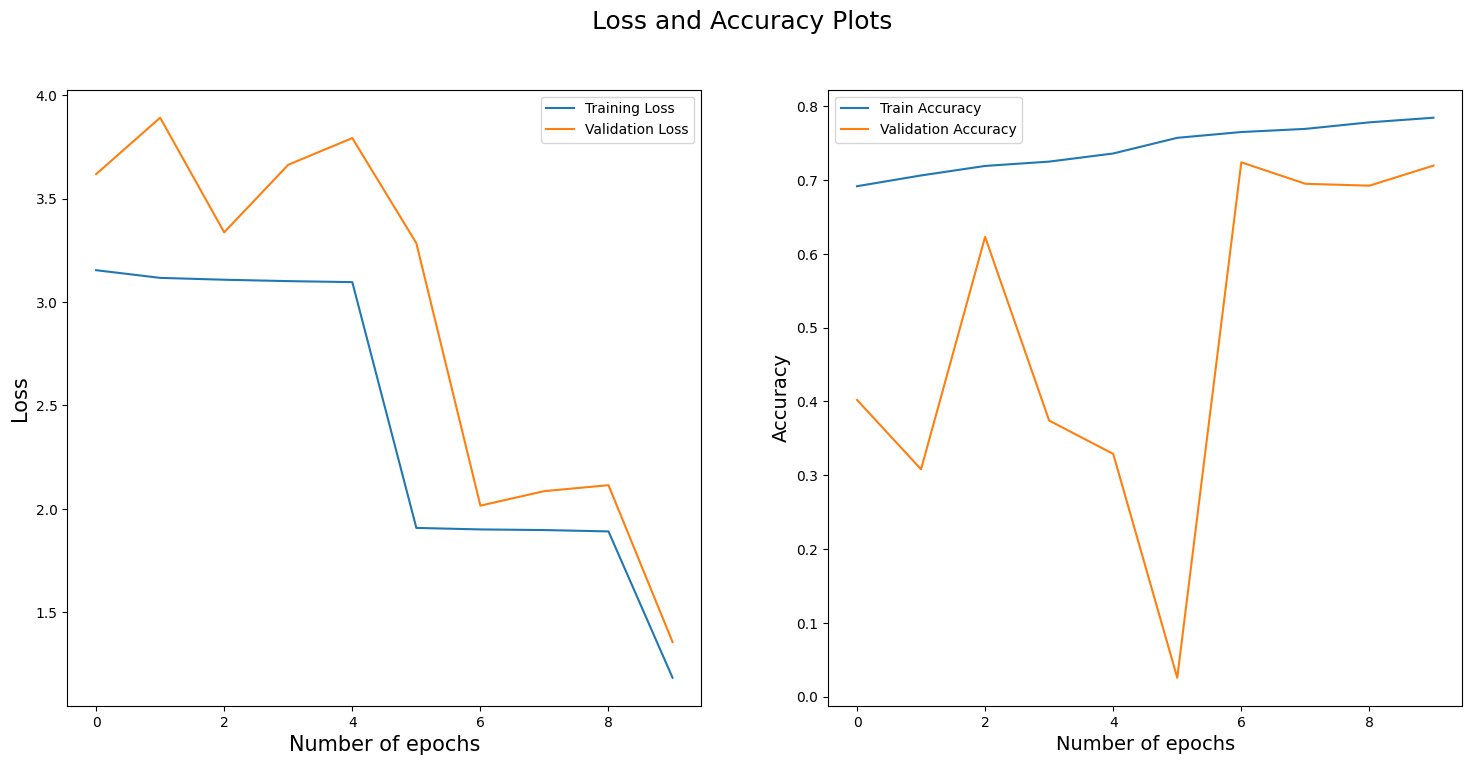

In [13]:
def show_history(history):
    plt.figure(figsize=(18,8))

    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

show_history(history)

In [14]:
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)


Found 50500 validated image filenames belonging to 101 classes.
Found 50500 validated image filenames belonging to 101 classes.


In [9]:
import keras
import numpy as np 
from tqdm import tqdm 
import tensorflow as tf

from glob import glob
import pathlib

from keras.preprocessing.image import img_to_array, load_img



from PIL import Image

import shutil
import matplotlib.pyplot as plt
import numpy as np


import os
import subprocess
from IPython.display import FileLink, display

In [10]:


def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [11]:
download_file('/kaggle/working/weights_food101_efb5_e35.weights.h5', 'food1013')

/kaggle/working/food1013.zip

In [15]:
pred_test = model.predict(test_gen)
pred_train = model.predict(train_gen)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 441s 273ms/step
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1178s 746ms/step


In [16]:
def report(true_labels, pred_labels, gen, n_clases=101):
    
    with pd.option_context("future.no_silent_downcasting", True):
        true_labels = true_labels.replace(gen.class_indices).infer_objects(copy=False)
    true_labels = keras.utils.to_categorical(true_labels, num_classes=n_clases)


    predicted_classes = np.argmax(pred_labels, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    print(classification_report(true_classes, predicted_classes))

    cm = confusion_matrix(true_classes, predicted_classes)


    plt.figure(figsize=(101, 101))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    

## Report on test data

In [17]:
report(test['y'], pred_test, test_gen)

              precision    recall  f1-score   support

           0       0.44      0.49      0.46       500
           1       0.56      0.52      0.54       500
           2       0.74      0.81      0.78       500
           3       0.71      0.84      0.77       500
           4       0.77      0.32      0.45       500
           5       0.62      0.66      0.64       500
           6       0.72      0.83      0.77       500
           7       0.93      0.83      0.88       500
           8       0.55      0.41      0.47       500
           9       0.73      0.62      0.67       500
          10       0.69      0.70      0.70       500
          11       0.87      0.71      0.78       500
          12       0.90      0.78      0.84       500
          13       0.75      0.80      0.77       500
          14       0.73      0.65      0.69       500
          15       0.59      0.69      0.64       500
          16       0.73      0.84      0.78       500
          17       0.56    

## Report on train data

In [18]:
report(train['y'], pred_train, train_gen)

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       500
           1       0.69      0.52      0.59       500
           2       0.92      0.98      0.95       500
           3       0.87      0.97      0.92       500
           4       0.90      0.48      0.62       500
           5       0.90      0.87      0.88       500
           6       0.91      0.96      0.93       500
           7       0.98      0.96      0.97       500
           8       0.85      0.67      0.75       500
           9       0.91      0.87      0.89       500
          10       0.96      0.92      0.94       500
          11       0.97      0.93      0.95       500
          12       0.97      0.95      0.96       500
          13       0.95      0.96      0.96       500
          14       0.94      0.86      0.90       500
          15       0.91      0.93      0.92       500
          16       0.95      0.99      0.97       500
          17       0.82    

## TF lite

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpf79picnf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 101), dtype=tf.float32, name=None)
Captures:
  135773616572896: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135775572301728: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135772804413776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135772804665008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135772804662368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135772804664480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135772804661488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135772804669408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135772804668352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135772804672224: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [20]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

116685904